In [5]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using Optim
import ProgressMeter


In [6]:
import ReactiveMP.messageout

In [7]:
include("../helpers/data.jl")

generate_data

In [8]:
function ssm(series, order)
    inputs = [reverse!(series[1:order])]
    outputs = [series[order + 1]]
    for x in series[order+2:end]
        push!(inputs, vcat(outputs[end], inputs[end])[1:end-1])
        push!(outputs, x)
    end
    return inputs, outputs
end

ssm (generic function with 1 method)

In [9]:
data_seed, params_seed = 42, 120

(42, 120)

In [10]:
order_y, order_u, order_h = 2, 2, 2
full_order = order_h + order_y + order_u
Y = zeros(full_order, order_y); Y[1:order_y, 1:order_y] = diageye(order_y);
U = zeros(full_order, order_u); U[order_y+1:order_y+order_u, 1:order_u] = diageye(order_u);
H = zeros(full_order, order_h); H[full_order-order_h+1:full_order, 1:order_h] = diageye(order_h);

In [11]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_mv(n, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u, y_order, u_order, h_order)
    
    order = h_order + y_order + u_order
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(h_order), 1e12*diageye(h_order)))}  
    w       = randomvar()
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Multivariate, h_order, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(order_h), 1e12*diageye(order_h))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2])
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(order))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max_mv (generic function with 1 method)

In [31]:
function nonlinear_max_inference_mv(observations, observations_prev, controls, model_flow::FlowModel, params;  
                                    y_order, u_order, h_order,
                                    h_prior=(zeros(h_order), 0.1*diageye(h_order)),
                                    w_prior=(0.1, 1.0), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max_mv(n, model_flow, params, h_prior, w_prior,
                                                                               observations_prev, controls,
                                                                               y_order, u_order, h_order,
                                                                               options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(h_order), diageye(h_order)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference_mv (generic function with 1 method)

In [32]:
# specify flow model
model_flow = FlowModel(full_order,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [33]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_h),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [34]:
observations_prev, observations = ssm(y_obs, order_y)
controls = ssm(u, order_u)[1]

1008-element Vector{Vector{Float64}}:
 [2.727892280477045, 2.5244129544236893]
 [0.4233600241796016, 2.727892280477045]
 [-2.2704074859237844, 0.4233600241796016]
 [-2.8767728239894153, -2.2704074859237844]
 [-0.8382464945967776, -2.8767728239894153]
 [1.9709597961563672, -0.8382464945967776]
 [2.9680747398701453, 1.9709597961563672]
 [1.2363554557252698, 2.9680747398701453]
 [-1.6320633326681093, 1.2363554557252698]
 [-2.9999706196521103, -1.6320633326681093]
 [-1.609718754001305, -2.9999706196521103]
 [1.2605011104799226, -1.609718754001305]
 [2.971822067084611, 1.2605011104799226]
 ⋮
 [-2.5664194559090623, -2.6939024414938535]
 [-0.07938225821119238, -2.5664194559090623]
 [2.4806386215960075, -0.07938225821119238]
 [2.7599717927589653, 2.4806386215960075]
 [0.5017996259213775, 2.7599717927589653]
 [-2.2177248028207854, 0.5017996259213775]
 [-2.8982832754114494, -2.2177248028207854]
 [-0.9141734707069559, -2.8982832754114494]
 [1.9104232070385518, -0.9141734707069559]
 [2.97858559860

In [35]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

In [36]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = randn(flow_param_len)

45-element Vector{Float64}:
 -0.9194589934298287
  1.0117762040383562
 -0.008656271104353946
 -1.7061637862602859
 -0.38240881051735015
  1.142903405886922
  1.5994173837327952
 -0.6606269914068376
  1.7280026513115074
 -0.13897835603040912
 -0.6737809225295219
  0.04878749639808164
  1.67258141660508
  ⋮
 -0.27993479669913585
 -0.8271189269423392
 -1.2688151069939353
  0.5442892692759611
  0.9515135579177358
 -2.2502731970794416
 -1.8241177727907605
  0.5887138745053259
  0.6765822621496003
  0.29873821278434554
  0.35665768910493706
 -0.5512200526575644

In [78]:
@time fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, model_params, w_prior=(1e4, 1e0), y_order=order_y, u_order=order_u, h_order=order_h, vmp_its=5);


  0.802388 seconds (4.62 M allocations: 392.346 MiB, 23.87% gc time)


In [79]:
inv(mean(w_))

0.46524687898077055

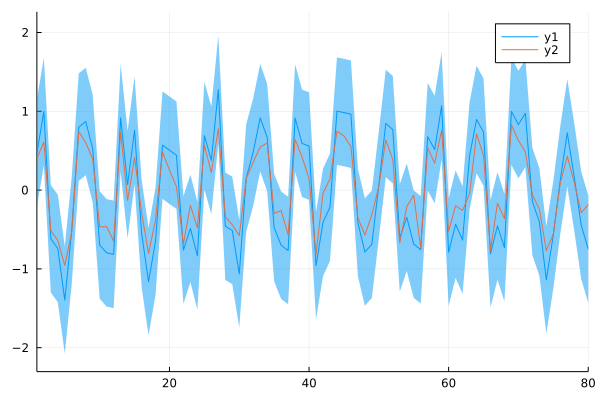

In [80]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

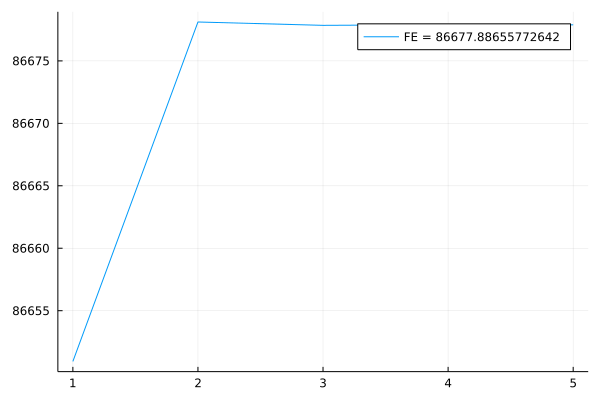

In [81]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [85]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, params,
                                                             y_order=order_y, u_order=order_u, h_order=order_h,
                                                             h_prior=(zeros(order_h), 0.1*diageye(order_h)),
                                                             w_prior=(1e4, 1.0), vmp_its=5)
    return fe[end]
end;

In [86]:
using ForwardDiff
@time ForwardDiff.gradient(FE, model_params)

  7.911386 seconds (20.93 M allocations: 6.659 GiB, 49.06% gc time, 0.60% compilation time)


45-element Vector{Float64}:
   952.0510632095355
  -908.3049206247689
  -726.9295833482815
 -1018.0048135856586
   329.5616323659929
   926.6554411375905
  -474.8727728202706
    19.575372579332864
   572.4156608586936
 -2343.3725478038896
  -392.168698326353
   288.0187782534337
  1411.5850747284721
     ⋮
  -642.3209498126851
   260.827448205997
  -215.76578377144804
    74.74210216993364
    -3.441788743366658
   -27.430256290807662
  -417.38612861064064
   553.6716824355603
  1716.9394986882962
   631.2918492972407
   807.9110848286361
   235.4105167048141

In [19]:
# NOTE: run in case of emergency
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [ ]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_nn_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

In [472]:
res = optimize(FE, model_params, GradientDescent(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     8.667784e+04     2.794091e+03
 * time: 0.00010609626770019531
    10     3.937065e+04     1.870013e+04
 * time: 325.7623381614685
    20     2.607435e+04     1.623102e+04
 * time: 520.0160322189331
    30     1.715663e+04     1.225468e+04
 * time: 1626.13920211792


 * Status: success

 * Candidate solution
    Final objective value:     1.710674e+04

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.29e+04 ≰ 1.0e-08

 * Work counters
    Seconds run:   2563  (vs limit Inf)
    Iterations:    33
    f(x) calls:    308
    ∇f(x) calls:   308


In [473]:
inf_params = Optim.minimizer(res)


45-element Vector{Float64}:
 -0.817087991274592
  1.0974126739909527
  0.49225103942656545
 -0.8474222123776565
 -0.7303048966413868
 -0.10849198961374912
  1.5732042926895466
 -1.1355275953779875
  0.8188668785687324
  1.2723366373392526
 -0.9613155137318168
  0.05258117991747441
  1.2757718193597714
  ⋮
  0.16082317962927578
 -0.9779442671682554
 -1.1386525977155597
  0.8288023548334118
  0.9822759459651806
 -2.2258724650474444
 -1.950351799169915
  1.0502528882687894
 -0.2720876253123701
  0.00923302046219805
 -0.010095027583584514
 -0.648947152279552

In [486]:
using JLD
JLD.save("../dump/flow_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [475]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference_mv(Y_train, X_train, U_train, model_flow, inf_params,
                                                                y_order=order_y, u_order=order_u, h_order=order_h,
                                                                h_prior=(zeros(order_h), 0.1*diageye(order_h)),
                                                                w_prior=(1.0, 1.0), vmp_its=10);


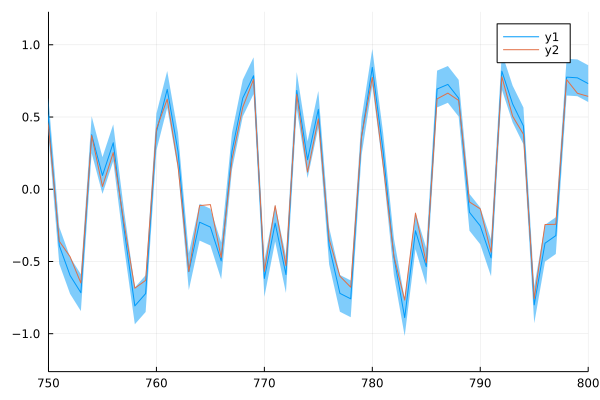

In [476]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(750, 800))

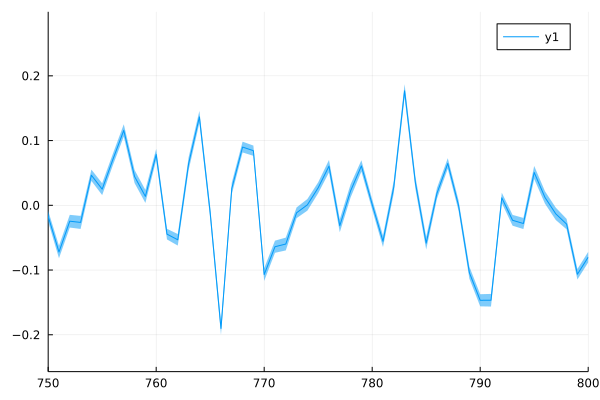

In [477]:
plot(first.(mean.(h_)), ribbon=sqrt.(first.(cov.(h_))),  xlims=(750, 800))

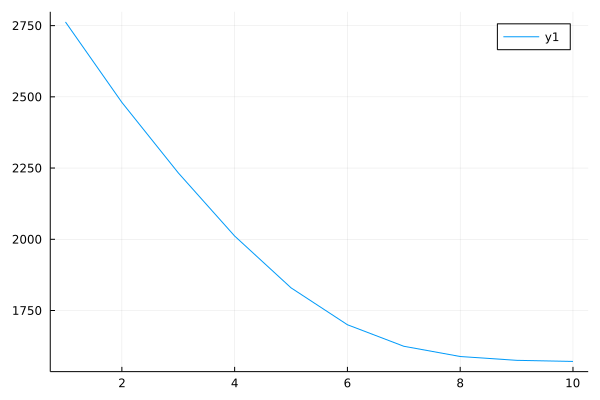

In [478]:
plot(fe_)

### KF-like prediction

In [479]:
function transition(γ, order)
    V = zeros(order, order)
#     V = 1e-12*diageye(order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [480]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_mv_model(model_flow::FlowModel, params, h_prior, w, y_prev, u, full_order)
    
    h_order = length(h_prior[1])

    A = shift(h_order) # transition matrix
    V = transition(w, h_order)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    
    Ah ~ A*h_0
    h ~ MvNormalMeanCovariance(Ah, V) where {q = q(Ah, h)q(V)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(full_order))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_mv_model (generic function with 1 method)

In [481]:
function nonlinear_max_prediction_mv(observation_prev, control, model_flow::FlowModel, params; full_order, 
                                     h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50)

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_mv_model(model_flow, params, h_prior, w,
                                                                                             observation_prev, control, full_order,
                                                                                             options = (limit_stack_depth = 500, ))
    
    h_order = length(h_prior[1])
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction_mv (generic function with 1 method)

In [482]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction_mv(X_test[i], U_test[i], model_flow, inf_params, full_order=full_order, h_prior=h_prev, w=ŵ, vmp_its=1)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference_mv([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, y_order=order_y, u_order=order_u, h_order=order_h, h_prior=h_prev, w_prior=(shape(w_), rate(w_)), vmp_its=1);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [483]:
mx, vx = mean.(predictions), cov.(predictions);

In [484]:
test_from, test_to = 1, 100

(1, 100)

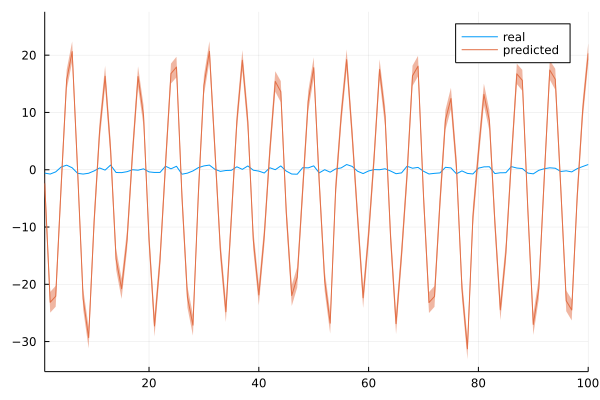

In [485]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")